<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

A Loggi é uma empresa brasileira de logística que revolucionou a forma como as encomendas são entregues no pais, fazendo cerca de 500 mil entregas por dia em todo o Brasil, no nosso projeto iremos lidar com os dados de delivery de Brasilia para responder algumas demandas.



1.   A quantidade de HUB's** de distribuição está subdimensionada?
2.   A distribuição de entregas por HUB está equilibrada?

 ***(Hub logístico: É um centro de distribuição estratégico, onde as mercadorias são recebidas, classificadas, armazenadas e despachadas para seus destinos finais.)*



## 2\. Pacotes e bibliotecas

In [ ]:
# importe todas as suas bibliotecas aqui, siga os padrões do PEP8:
!pip3 install geopandas


import json


import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns

*Download dos arquivos*

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

## 3\. Exploração de dados

In [ ]:
# Define o caminho do arquivo JSON contendo os dados de entrega
DELIVERY_DADOS = './deliveries.json'
# Lê o arquivo JSON em um DataFrame Pandas
with open(DELIVERY_DADOS, mode='r', encoding='utf8') as file:
  data = json.load(file)
deliveries_df = pd.DataFrame(data)

# Extrai as informações do hub de origem e mescla de volta ao DataFrame principal
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1) # Remove a coluna 'origin' original
# Seleciona apenas as colunas relevantes para o hub e renomeia algumas para maior clareza
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
# "Explode" a coluna 'deliveries' para ter uma linha por entrega individual
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
# Extrai as informações relevantes de cada entrega (tamanho, longitude, latitude)
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
# Remove a coluna 'deliveries' original e mescla as informações normalizadas das entregas
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
# Redefine o índice do DataFrame para facilitar a manipulação posterior
deliveries_df.reset_index(inplace=True, drop=True)

Imagine que você tem uma caixa de ferramentas com várias gavetas. Cada gaveta tem ferramentas diferentes misturadas. Esse código é como se ele pegasse todas as ferramentas, separasse por tipo, organizasse em caixinhas menores (cada caixinha representando uma entrega) e colocasse etiquetas em cada caixinha com os detalhes da ferramenta (tamanho, tipo, etc.). Agora você pode encontrar e analisar as ferramentas (entregas) muito mais facilmente!

## 4\. Manipulação

In [ ]:
# Cria um novo DataFrame (hub_df) contendo apenas as colunas relevantes para os hubs: região, longitude e latitude
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
# Remove linhas duplicadas do DataFrame, garantindo que cada hub seja representado apenas uma vez
hub_df = hub_df.drop_duplicates()
# Ordena o DataFrame pela coluna "region" em ordem alfabética
hub_df = hub_df.sort_values(by="region")
# Redefine o índice do DataFrame para uma sequência numérica simples começando em 0
hub_df = hub_df.reset_index(drop=True)
# Exibe as 5 primeiras linhas do DataFrame resultante para verificar o resultado
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [ ]:
# Cria um objeto geolocator do tipo Nominatim, especificando o user_agent
# O user_agent identifica seu aplicativo para o provedor de geocodificação
geolocator = Nominatim(user_agent="wellington_aluno_ebac")
# Cria um objeto geocoder que limita a taxa de chamadas à função geolocator.reverse
# Define um atraso mínimo de 1 segundo entre as chamadas para evitar sobrecarga no serviço
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
# Combina as colunas de latitude e longitude em uma única coluna "coordenadas" no formato "latitude, longitude"
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
# Aplica a função geocoder (provavelmente usando o RateLimiter para evitar sobrecarregar o serviço de geocodificação)
# a cada par de coordenadas na coluna "coordenadas". Armazena as informações de localização resultantes na coluna "geodata"
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
# Exibe as 5 primeiras linhas do DataFrame para inspecionar os resultados (incluindo as novas colunas "coordenadas" e "geodata")
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [ ]:
# Normalizar os dados brutos de geolocalização (JSON) em um novo DataFrame,
# extraindo informações relevantes como endereço, cidade, estado, país, etc.
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.053411,...,Distrito Federal,BR-DF,Região Centro-Oeste,70330-400,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [ ]:
# Seleciona apenas as colunas relevantes para o DataFrame: cidade, bairro e município.
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
# Renomeia as colunas para um formato mais intuitivo, utilizando os prefixos "hub_"
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
# Preenche os valores ausentes (NaN) na coluna "hub_city" com os valores correspondentes da coluna "hub_town"
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
# Preenche os valores ausentes (NaN) na coluna "hub_suburb" com os valores correspondentes da coluna "hub_city"
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
# Remove a coluna "hub_town", pois seus valores já foram utilizados para preencher dados ausentes em outras colunas.
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
# Exibe as primeiras linhas do DataFrame para verificar as alterações e os novos nomes das colunas.
hub_geodata_df.head()

<ipython-input-8-36e164dc9035>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
<ipython-input-8-36e164dc9035>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
<ipython-input-8-36e164dc9035>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [ ]:
# Combinar o DataFrame original (hub_df) com o DataFrame com os dados de geolocalização (hub_geodata_df)
# A junção é feita com base nos índices (left_index=True, right_index=True) para garantir que as linhas correspondentes sejam combinadas corretamente
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
# Seleciona apenas as colunas relevantes para o DataFrame: região, bairro e cidade
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
# Exibe as primeiras linhas do DataFrame para verificar as alterações e os novos nomes das colunas.
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [ ]:
# Combinar o DataFrame de entregas (deliveries_df) com o DataFrame com os dados do hub (hub_df),
# usando a coluna 'region' como chave.
# O tipo de junção é "inner", o que significa que apenas as linhas com valores de 'region' correspondentes em ambos os DataFrames serão incluídas no resultado.
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
# Seleciona apenas as colunas relevantes do DataFrame resultante: nome, região, longitude e latitude do hub,
# cidade e bairro do hub, capacidade do veículo, tamanho da entrega, e longitude e latitude da entrega.
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
# Exibe as 5 primeiras linhas do DataFrame resultante para verificar o resultado da junção e seleção das colunas.
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


In [ ]:
# Aqui estamos lendo o arquivo CSV que fizemos download no segundo  logo no cabeçalho deste notebook
ARQUIVO_GEODATA = "deliveries-geodata.csv"
deliveries_geodata_df = pd.read_csv(ARQUIVO_GEODATA)
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
# Combinar o DataFrame de entregas (deliveries_df) com as informações de cidade e bairro das entregas (deliveries_geodata_df)
# A junção é feita com base nos índices (left_index=True, right_index=True) para garantir que as linhas correspondentes sejam combinadas corretamente.
# Apenas as colunas "delivery_city" e "delivery_suburb" de deliveries_geodata_df são utilizadas.
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [ ]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [ ]:
deliveries_df.nunique()

name                   199
region                   3
hub_lng                  3
hub_lat                  3
hub_city                 3
hub_suburb               3
vehicle_capacity         1
delivery_size           10
delivery_lng        291566
delivery_lat        291566
delivery_city           38
delivery_suburb        167
dtype: int64

In [ ]:
var_numericos = []
var_categoricas = []

for coluna in deliveries_df.columns:
  if deliveries_df[coluna].dtype != "object":
    var_numericos.append(coluna)
  else:
    var_categoricas.append(coluna)

print(f'As colunas numéricas são: {var_numericos}')
print(f'As colunas categóricas são: {var_categoricas}')

As colunas numéricas são: ['hub_lng', 'hub_lat', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat']
As colunas categóricas são: ['name', 'region', 'hub_city', 'hub_suburb', 'delivery_city', 'delivery_suburb']


In [ ]:
deliveries_df[var_numericos].describe().T

,count,mean,std,min,25%,50%,75%,max
hub_lng,636149.0,-47.949902,0.091875,-48.054989,-48.054989,-47.893662,-47.893662,-47.802665
hub_lat,636149.0,-15.802359,0.053463,-15.838145,-15.838145,-15.805118,-15.805118,-15.657014
vehicle_capacity,636149.0,180.000000,0.000000,180.000000,180.000000,180.000000,180.000000,180.000000
delivery_size,636149.0,5.512111,2.874557,1.000000,3.000000,6.000000,8.000000,10.000000
delivery_lng,636149.0,-47.946087,0.112769,-48.280779,-48.035911,-47.928967,-47.883394,-47.310611
delivery_lat,636149.0,-15.809492,0.082462,-16.050028,-15.842795,-15.814033,-15.769516,-15.500355


Olha que interessante, percebemos no describe dos valores numericos, que a linha "vehicle_capacity" não possuiu variaçoes, parmanecendo em 180 em todos os Quartis e em zero no desvio padrão.

Tambem na mesma descrição, podemos ver o delivery size, que o minimo de capacidade de um veiculo é de um (1) sendo o maximo 10, e media 5.5 por veiculo.

## 5\. Visualização

In [ ]:
#Aqui fazemos download dos dados direto do ibge.

!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [ ]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [ ]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


<ipython-input-23-3e6bf7ab426f>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


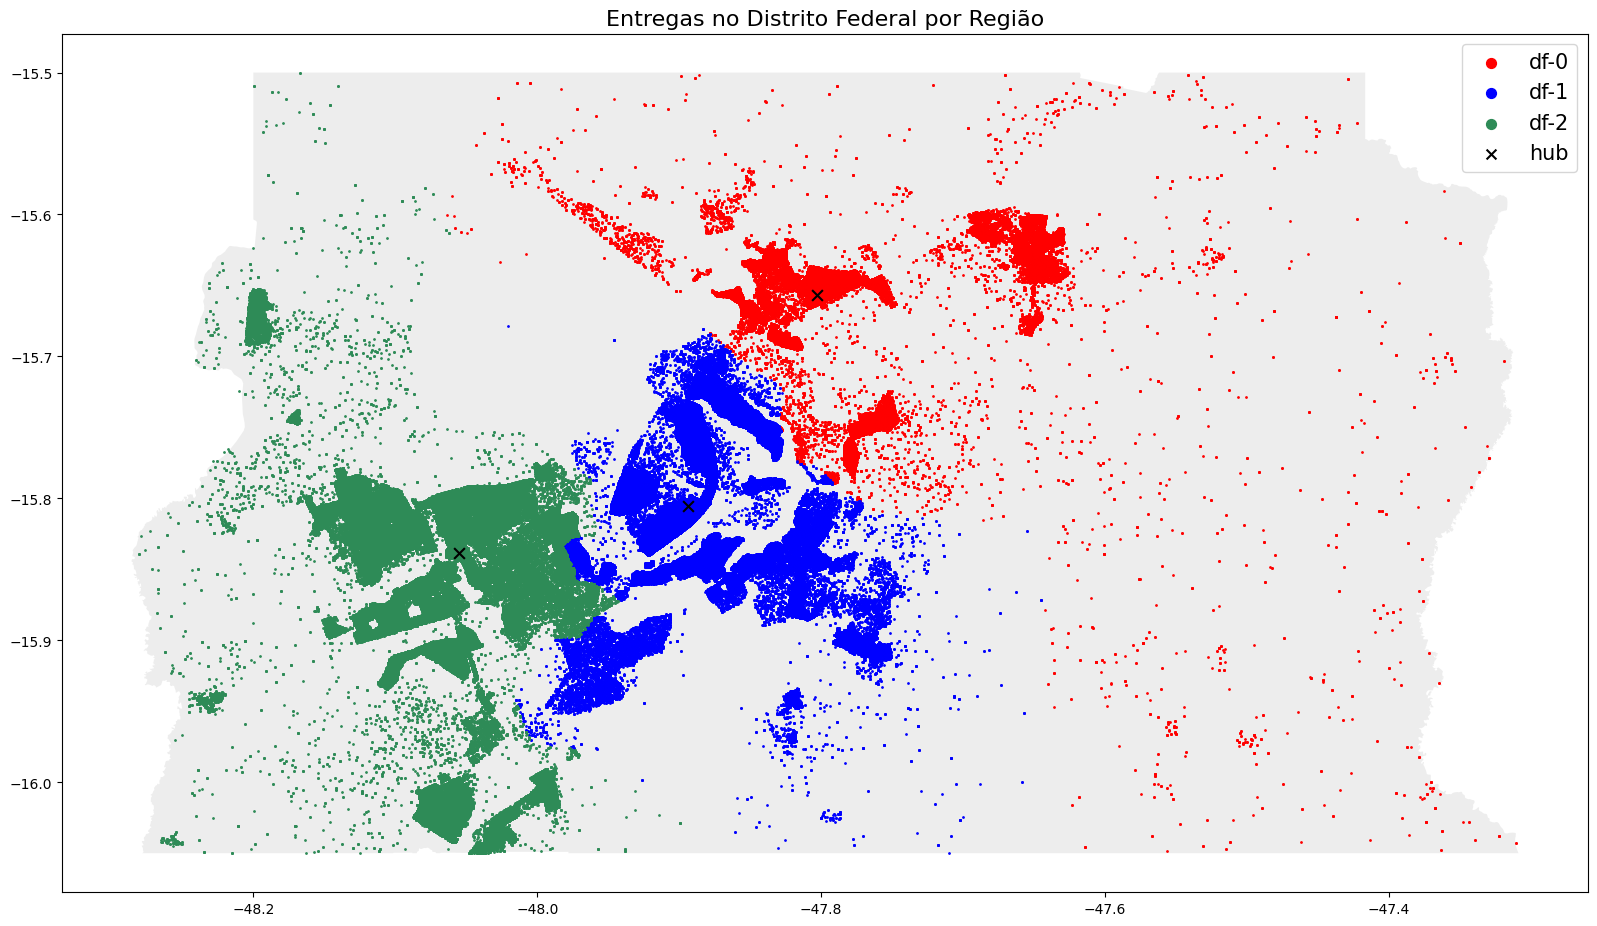

In [ ]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=60, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])



*   Verificamos que as **entregas** estão dentro da area de atuação de seus respectivos **hubs** logisticos.
*   O **hub** zero(0) tem muitas entregas distantes uma das outras.
*   O **hub** dois(2) tambem possuiu entregas espaçadas uma das outras, porém menos que o **hub** zero(0)
*   O **hub** um (1) Esta com as entregas bem centralizadas.





In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.head()

,region,vehicle_capacity,proportion
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


<ipython-input-31-4e5092e1fa1e>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="proportion", ci=None, palette="pastel")
<ipython-input-31-4e5092e1fa1e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="proportion", ci=None, palette="pastel")


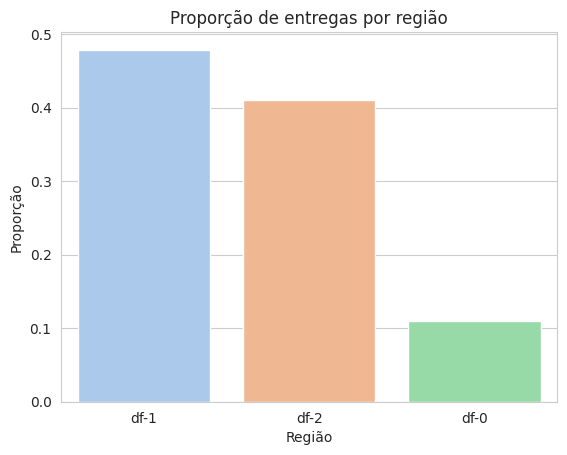

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="proportion", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');



*   Podemos notar, que cerca de 90% das entregas estão concentradas na região dos **hubs** um(1) e dois (2), mas pouco no região zero (0). Porém a capacidade de veiculos dos **hubs** se mantem a mesma entre as três, não seria possivel deslocar esses veiculos para ajudar os outros **hubs?**








# Respondendo nossas questões.



1. A quantidade de HUB's** de distribuição está subdimensionada?

*  Sendo bem direto, não, a Loggi tem seus hubs com capacidade para entregar suas demandas.*

2.  A distribuição de entregas por HUB está equilibrada?

* *Percemos que não esta equilibrada, praticamente 90% da operação esta ocorrendo nos huns um (1) e dois (2).*
